# 1. Nhập dữ liệu

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
#Lấy luôn dữ liệu đã loc của tác giả
random_state = 5

test_path = "../data_for_modeling/filter_data/v1/test_" + str(random_state) + ".csv"; 
train_path = "../data_for_modeling/filter_data/v1/train_" + str(random_state) + ".csv"; 

train_dataset = pd.read_csv(train_path)
test_dataset = pd.read_csv(test_path)

# 2. Xây dựng mô hình với Morgan2

## 2.1. Mã hóa cấu trúc phân tử

In [96]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [97]:
train_morgan_fpts = morgan_fpts(train_dataset['SMILES'])
test_morgan_fpts = morgan_fpts(test_dataset['SMILES'])

In [98]:
X_Train = train_morgan_fpts
X_Test = test_morgan_fpts
y_Train = np.array(train_dataset['FINAL_LABEL'])
y_Test = np.array(test_dataset['FINAL_LABEL'])

## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [99]:
from sklearn.ensemble import RandomForestClassifier
rf_morgan2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_morgan2.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn_morgan2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_morgan2.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [101]:
from sklearn.svm import SVC
svm_morgan2 = SVC(kernel='rbf', random_state=0)
svm_morgan2.fit(X_Train, y_Train)

SVC(random_state=0)

__XGBoost__

In [102]:
from xgboost import XGBClassifier
bst_morgan2 = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_morgan2.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [103]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [104]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

__RF__

In [105]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.827 (0.023)


__KNN__

In [106]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(knn_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.778 (0.031)


__SVM__

In [107]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.807 (0.031)


__XGBoost__

In [108]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(bst_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation: 0.811 (0.027)


### 2.3.2. Accuracy, Sensitivity, Specificity

In [109]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [110]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [111]:
def me_result(cm):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

RF

In [112]:
#Random Forest
y_rf_pred = rf_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_rf_pred)
me_result(cm)

Confusion matrix:
[[84 17]
 [18 78]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.822335 │ 0.823529 │ 0.821053 │ 0.644383 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


KNN

In [113]:
#KNN
y_knn_pred = knn_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_knn_pred)
me_result(cm)

Confusion matrix:
[[85 16]
 [28 68]]
Comparision:
╒══════════╤═════════╤══════════╤══════════╤══════════╕
│          │      AC │       SE │       SP │      MCC │
╞══════════╪═════════╪══════════╪══════════╪══════════╡
│ My model │ 0.77665 │ 0.752212 │ 0.809524 │ 0.555795 │
╘══════════╧═════════╧══════════╧══════════╧══════════╛


SVM

In [114]:
#SVM
y_svm_pred = svm_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_svm_pred)
me_result(cm)

Confusion matrix:
[[85 16]
 [16 80]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.837563 │ 0.841584 │ 0.833333 │ 0.674917 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


XGBoost

In [115]:
y_bst_pred = bst_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_bst_pred)
me_result(cm)

Confusion matrix:
[[82 19]
 [16 80]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.822335 │ 0.836735 │ 0.808081 │ 0.645015 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛


### 2.3.3. AUC

In [116]:
from sklearn.metrics import RocCurveDisplay

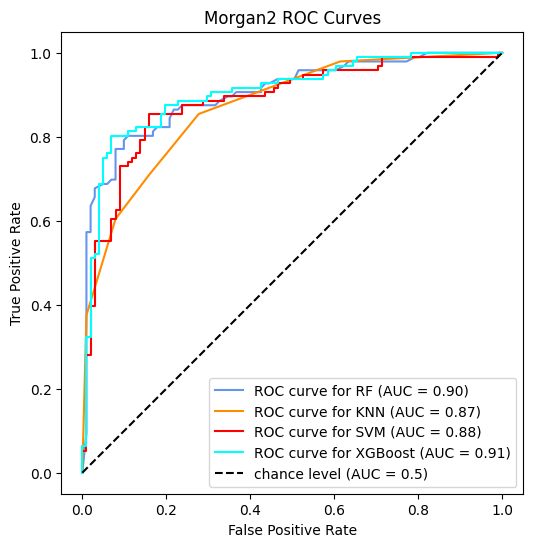

In [117]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Morgan2 ROC Curves")
plt.legend()
plt.show()